### Normal vae

In [1]:
def extract_latent_space(data, model):
    model.eval()
    bio_z, mu1, logvar1, batch_z, mu2, logvar2, bio_batch_pred, batch_batch_pred, reconstruction = model(data)
    z1 = bio_z
    z2 = batch_z
    return z1.cpu().numpy(), z2.cpu().numpy(), reconstruction.cpu().numpy()

## Load data

In [25]:
table = pd.read_csv('/home/haiping_liu/code/My_model/BioBatchNet/Data/IMC_data/csv_format/Damond_2019_Pancreas.csv')
# table = table[(table['cell_type'] == 'ductal') | (table['cell_type'] == 'acinar')]

data = table.iloc[:, 0:38].values 
batch_id =  pd.Categorical(table.iloc[:, 40]).codes
cell_type = table.iloc[:, 38].values 

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


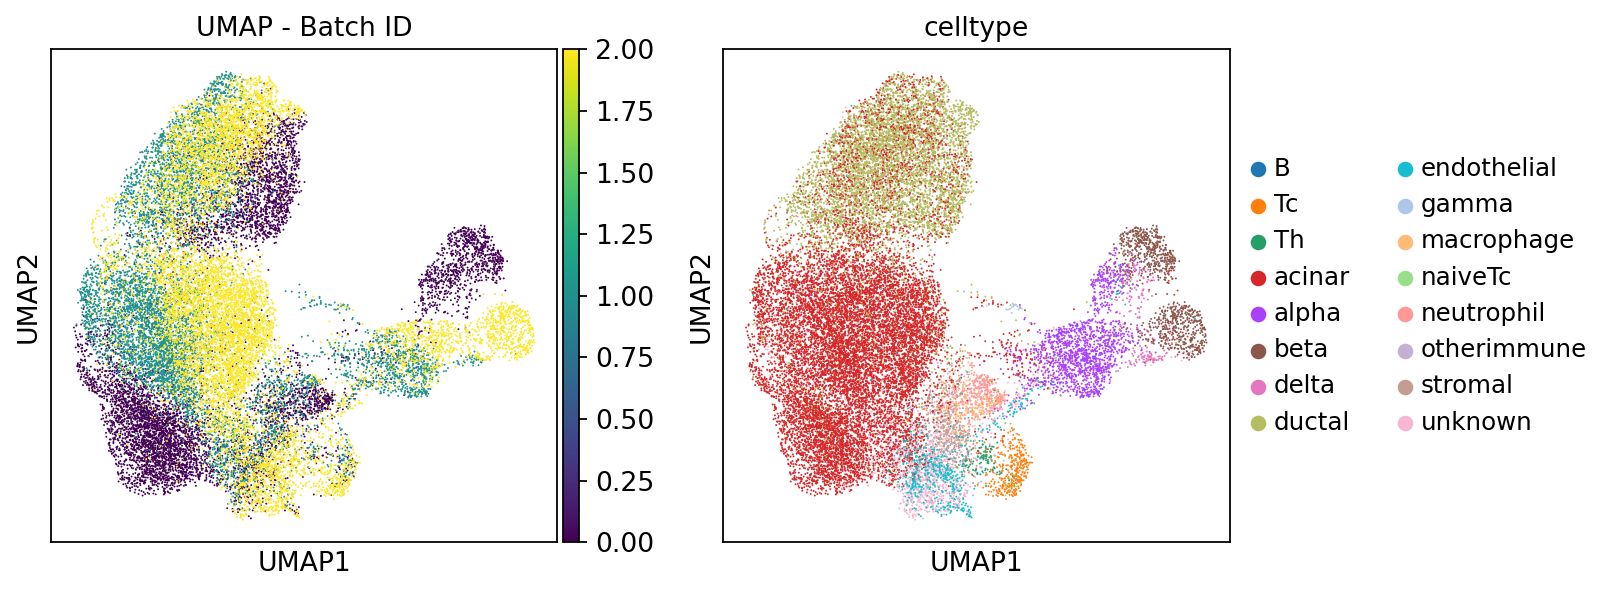

In [2]:
import torch
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# load data
table = pd.read_csv('/home/haiping_liu/code/My_model/BioBatchNet/Data/IMC_data/csv_format/Damond_2019_Pancreas.csv')
# table = table[(table['cell_type'] == 'ductal') | (table['cell_type'] == 'acinar')]

data = table.iloc[:, 0:38].values 
batch_id =  pd.Categorical(table.iloc[:, 40]).codes
cell_type = table.iloc[:, 38].values 

adata = sc.AnnData(data)  
adata.obs['BATCH'] = batch_id 
adata.obs['celltype'] = pd.Categorical(cell_type.astype(str))
# adata.write('/home/haiping_liu/code/My_model/Batch_VAE/Data/IMC_data/adatas/damond_adata.h5ad')

sc.pp.subsample(adata, fraction=0.1)
sc.pp.neighbors(adata, use_rep='X')  
sc.tl.umap(adata) 
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata, color=['BATCH', 'celltype'] , title="UMAP - Batch ID", size=3)
plt.show()

## Inference and visulization

In [3]:
import sys
import os
import scanpy as sc
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))

if project_root not in sys.path:
    sys.path.append(project_root)

from models.model import IMCVAE
from utils.dataset import GeneralDataset

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader

# load model
checkpoint_path = '/home/haiping_liu/code/My_model/BioBatchNet/saved/models/Damond/0119_221940/checkpoint-epoch40.pth'
checkpoint = torch.load(checkpoint_path)
config = checkpoint['config']._config if hasattr(checkpoint['config'], '_config') else checkpoint['config']
config_args = config['arch']['args']
model = IMCVAE(**config_args)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

dataset = GeneralDataset('Damond')
dataloader = DataLoader(dataset, batch_size=256)

features_list = []
cell_types = []
latent = []
batch_ids = []
z2_list = []

model.eval()
model.to('cuda') 
with torch.no_grad():
    for batch in dataloader:
        features, batch_id, cell_type = batch
        features = features.to('cuda')
        cell_type = cell_type.to('cuda')
        batch_id = batch_id.to('cuda')
        z1, z2, recon = extract_latent_space(features, model)

        features = features.cpu().numpy()
        features_list.append(features)
        latent.append(z1)
        z2_list.append(z2)
        cell_types.append(cell_type.cpu().numpy())
        batch_ids.append(batch_id.cpu().numpy())

features_combined = np.concatenate(features_list, axis=0)
latent =  np.concatenate(latent, axis=0)
cell_types = np.concatenate(cell_types, axis=0)
batch_ids = np.concatenate(batch_ids, axis=0)
z2_list = np.concatenate(z2_list, axis=0)

cell_type_names = dataset.cell_type_names
cell_types_named = [cell_type_names[code] for code in cell_types]

adata_z1 = sc.AnnData(latent)
adata_z1.obs['BATCH'] = pd.Categorical(batch_ids.astype(str))  
adata_z1.obs['celltype'] = pd.Categorical(cell_types_named)  

damond_adata = sc.AnnData(X=features_combined) 
damond_adata.obs['BATCH'] = pd.Categorical(batch_ids.astype(str)) 
damond_adata.obs['celltype'] = pd.Categorical(cell_types_named) 

/tmp/ipykernel_202086/4132187781.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/tmp/ipykernel_202086/4132187781.py:11: FutureW

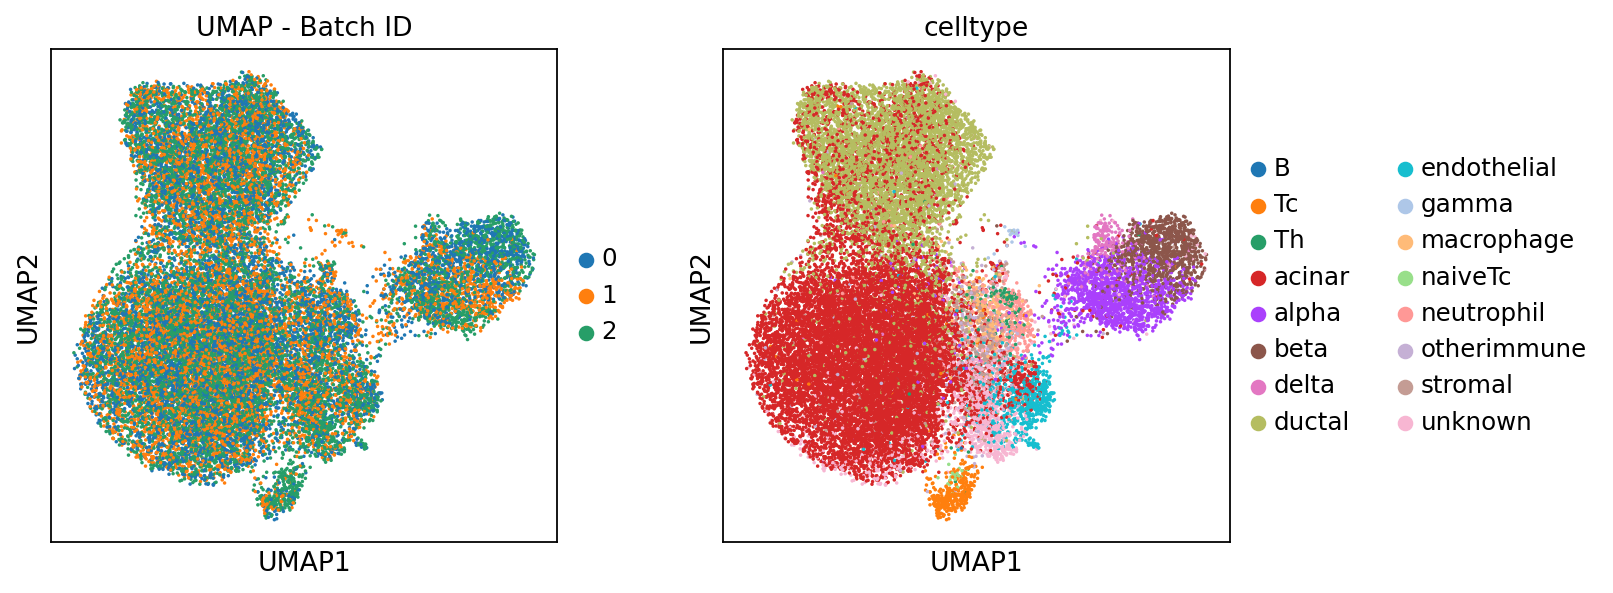

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt

# adata_z1 = adata_z1[adata_z1.obs['cell type'] != 'ductal']
sc.pp.subsample(adata_z1, fraction=0.1)
sc.pp.neighbors(adata_z1, use_rep='X')  
sc.tl.umap(adata_z1) 
sc.pl.umap(adata_z1, color=['BATCH', 'celltype'], title="UMAP - Batch ID", size=10)
plt.show()

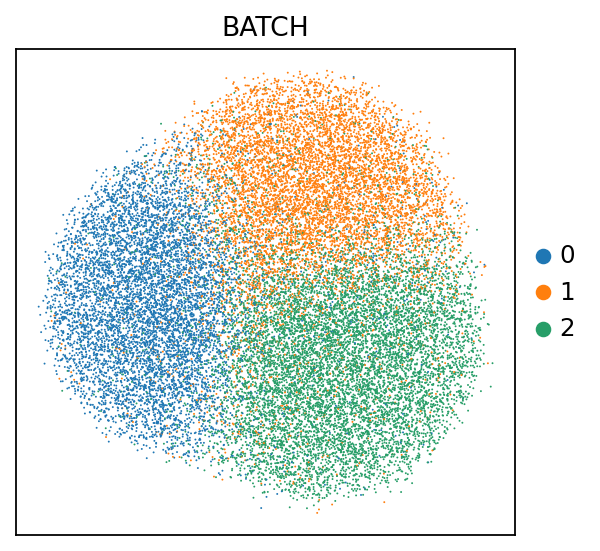

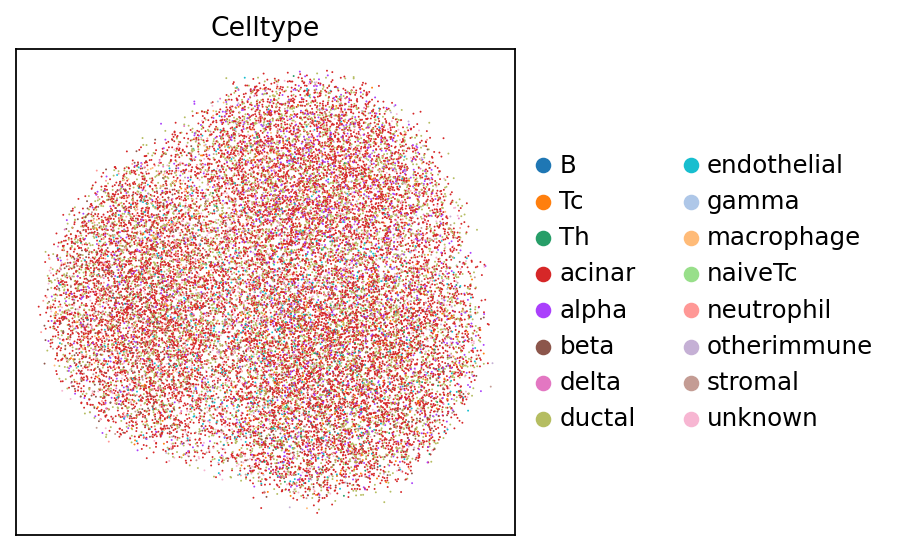

In [6]:
adata_z2 = sc.AnnData(z2_list)  
adata_z2.obs['BATCH'] = pd.Categorical(batch_ids.astype(str))  
adata_z2.obs['celltype'] = pd.Categorical(cell_types_named)  

# Compute neighbors and UMAP embedding
sc.pp.subsample(adata_z2, fraction=0.1)
sc.pp.pca(adata_z2)
sc.pp.neighbors(adata_z2, use_rep='X')
sc.tl.umap(adata_z2)

# Set figure parameters
sc.settings.set_figure_params(fontsize=12)

# Plot the UMAP for 'batch'
fig, ax = plt.subplots()
sc.pl.umap(
    adata_z2,
    color='BATCH',
    title='BATCH',  # Remove the title
    size=3,
    ax=ax,
    show=False  # Don't display immediately
)
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('')  # Remove y-axis label
plt.show()

# Plot the UMAP for 'cell type'
fig, ax = plt.subplots()
sc.pl.umap(
    adata_z2,
    color='celltype',
    title= 'Celltype',  # Remove the title
    size=3,
    ax=ax,
    show=False  # Don't display immediately
)
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('')  # Remove y-axis label
plt.show()

In [ ]:
adata_recon = sc.AnnData(recon)  
adata_recon.obs['batch'] = pd.Categorical(batch_id.astype(str))  
adata_recon.obs['cell type'] = pd.Categorical(cell_type.astype(str))

# visulization
sc.pp.neighbors(adata_recon, use_rep='X')  
sc.tl.umap(adata_recon) 
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata_recon, color=['batch', 'cell type'] , title="UMAP - Batch ID", size=3)
plt.show()

## Evaluation

### 1. Batch effect

In [24]:
import sys
import os
import importlib

scib_path = '/home/haiping_liu/code/My_model/Batch_VAE/Results/scib'
if scib_path not in sys.path:
    sys.path.append(scib_path)

import scib
importlib.reload(scib)

print(scib.__file__)

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/__init__.py


In [25]:
import scib
scib.metrics.ilisi_graph(adata_z1, batch_key='batch', type_="full")

0.7725315129027934

In [26]:
scib.me.graph_connectivity(adata_z1, label_key="cell type")

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

0.940647620318596

In [27]:
sc.pp.pca(adata_z1)
scib.me.silhouette_batch(adata_z1, batch_key="batch", label_key="cell type", embed='X_pca')

mean silhouette per group:              silhouette_score
group                        
Tc                   0.965953
Th                   0.957587
acinar               0.986155
alpha                0.932339
beta                 0.951265
delta                0.966194
ductal               0.982167
endothelial          0.973789
gamma                0.913500
macrophage           0.968935
naiveTc              0.884397
neutrophil           0.965920
otherimmune          0.951795
stromal              0.957188


0.9540845424754669

In [ ]:
# kbet
scib.me.kBET(adata_z1, batch_key="batch", label_key="cell type", type_="embed", embed="X_pca")

### 2. Biological information

In [ ]:
sc.pp.neighbors(adata_z1)
scib.me.cluster_optimal_resolution(adata_z1, cluster_key="cluster", label_key="cell type")
scib.me.ari(adata_z1, cluster_key="cluster", label_key="cell type")

In [ ]:
scib.me.nmi(adata_z1, cluster_key="cluster", label_key="cell type")

In [28]:
sc.pp.pca(adata_z1)
scib.me.silhouette(adata_z1, label_key="cell type", embed="X_pca")

0.5566755272448063

In [ ]:
scib.me.clisi_graph(adata_z1, label_key="cell type", type_="embed", use_rep="X_pca")

In [ ]:
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
)

sc.tl.leiden(adata_z1, resolution=0.4, key_added='leiden_clusters')
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata_z1, color=['leiden_clusters', 'cell type'], title="UMAP - Batch ID and Leiden Clusters", size=3)

cell_type_labels = adata_z1.obs['cell type']
leiden_labels = adata_z1.obs['leiden_clusters']

# Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(cell_type_labels, leiden_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(cell_type_labels, leiden_labels)
print(f"Normalized Mutual Information (NMI) score: {nmi_score}")

plt.subplots_adjust(wspace=1)
plt.show()